In [2]:
#https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.special import boxcox1p

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV,LassoCV,RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import sklearn.linear_model as linear_model

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

In [3]:
sns.set(rc={'figure.figsize':(12,6)})

In [4]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
train_data.sample(5)

y=train_data['SalePrice']

In [4]:
print('훈련: ',train_data.shape,'테스트',test_data.shape)

훈련:  (1460, 81) 테스트 (1459, 80)


In [5]:
#EDA(Exploratory Data Analysis)

#정량적, 정성적 데이터 분류해주기
quantative=[f for f in train_data.columns if train_data.dtypes[f]!='object']
quantative.remove('SalePrice')
quantative.remove('Id')
qualitative=[f for f in train_data.columns if train_data.dtypes[f]=='object']

[Text(0,0,'Electrical'),
 Text(0,0,'MasVnrType'),
 Text(0,0,'MasVnrArea'),
 Text(0,0,'BsmtQual'),
 Text(0,0,'BsmtCond'),
 Text(0,0,'BsmtFinType1'),
 Text(0,0,'BsmtExposure'),
 Text(0,0,'BsmtFinType2'),
 Text(0,0,'GarageCond'),
 Text(0,0,'GarageQual'),
 Text(0,0,'GarageFinish'),
 Text(0,0,'GarageType'),
 Text(0,0,'GarageYrBlt'),
 Text(0,0,'LotFrontage'),
 Text(0,0,'FireplaceQu'),
 Text(0,0,'Fence'),
 Text(0,0,'Alley'),
 Text(0,0,'MiscFeature'),
 Text(0,0,'PoolQC')]

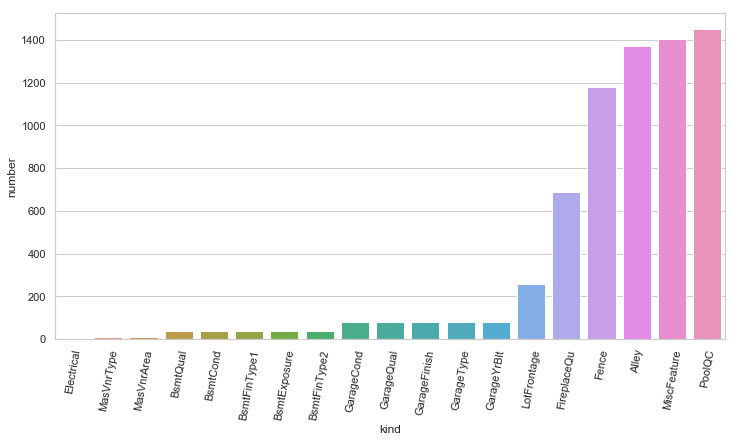

In [33]:
#nan인 데이터 그래프로 표현하기
sns.set(style='whitegrid')

missing=train_data.isnull().sum()
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing=missing.reset_index()
missing=missing.rename(columns={'index':'kind',0:'number'})

ax=sns.barplot(x='kind',y='number',data=missing)
ax.set_xticklabels(ax.get_xticklabels(),rotation=80)

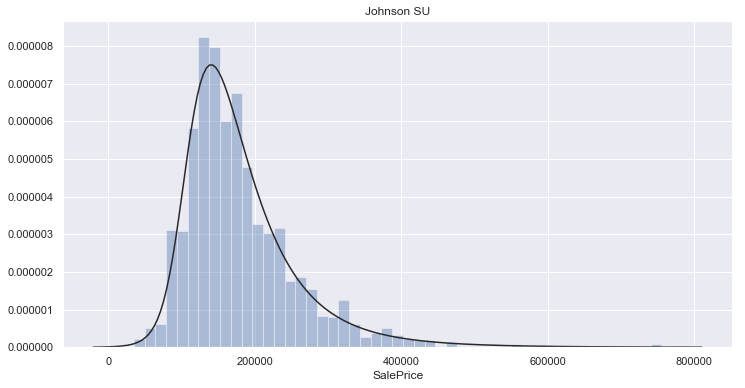

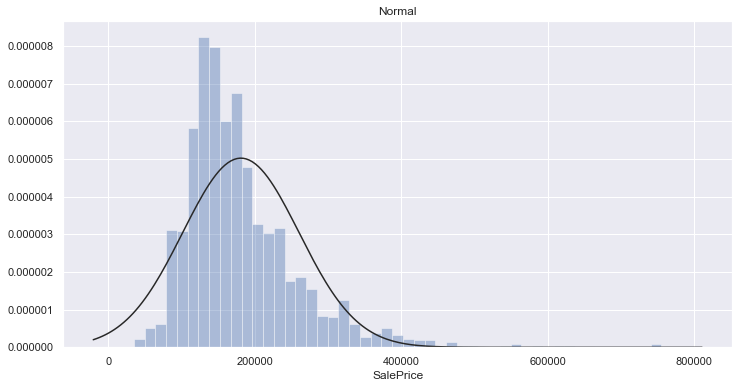

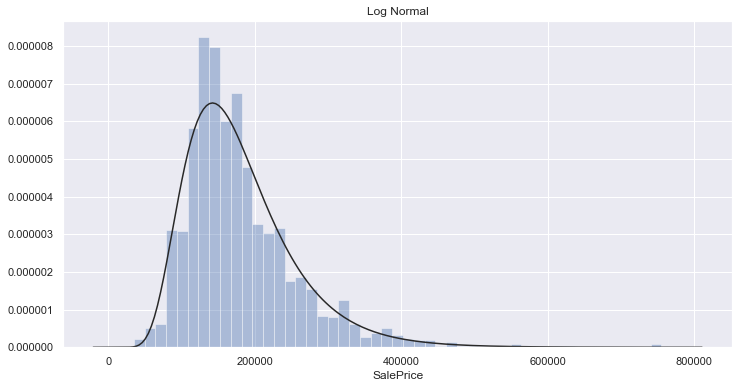

In [5]:
#sale price데이터가 어떤 분포를 띄고 있는지 확인

#kde->Whether to plot a gaussian kernel density estimate.
#johnson su->분포의 한 종류로 정규분포의 변형
plt.figure(1)
plt.title('Johnson SU')
sns.distplot(y,kde=False,fit=stats.johnsonsu)
plt.figure(2)
plt.title('Normal')
sns.distplot(y,kde=False,fit=stats.norm)
plt.figure(3)
plt.title('Log Normal')
sns.distplot(y,kde=False,fit=stats.lognorm)

In [5]:
#정량적 데이터의 정규성검정

#shapiro->정규성 검정(데이터가 정규분포를 따르는지 아닌지 확인해줌)
#0.01보다 작으면 정규분포 아닌걸로 판단
test_normality=lambda x: stats.shapiro(x.fillna(0))[1]<0.01
normal=pd.DataFrame(train_data[quantative])
normal=normal.apply(test_normality)
print(not normal.any())

False


In [6]:
#각 특성마다 특성 고유 데이터의 sale price 구하고 순서 정하기
def encoding(frame,feature):
    ordering=pd.DataFrame()
    ordering['val']=frame[feature].unique()
    ordering.index=ordering.val
    ordering['spmean']=frame[[feature,'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering=ordering.sort_values('spmean')
    ordering['ordering']=range(1,ordering.shape[0]+1)
    ordering=ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature]==cat, feature+'_E']=o
qual_encoded=[]
for q in qualitative:
    encoding(train_data,q)
    qual_encoded.append(q+'_E')
print(len(qual_encoded)==len(qualitative))

True


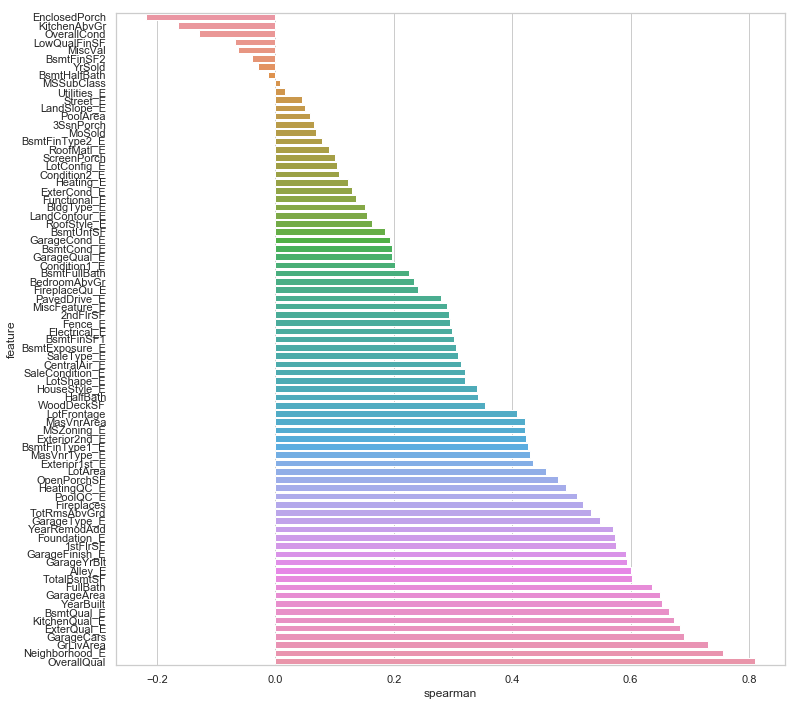

In [81]:
#spearman상관->순위 값이 매겨진 데이터에서 관계평가
def spearman(frame, features):
    spr=pd.DataFrame()
    spr['feature']=features
    spr['spearman']=[frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr=spr.sort_values('spearman')
    plt.figure(figsize=(12,12))
    ax=sns.barplot(data=spr,y='feature',x='spearman',orient='h')
features=quantative+qual_encoded
spearman(train_data,features)

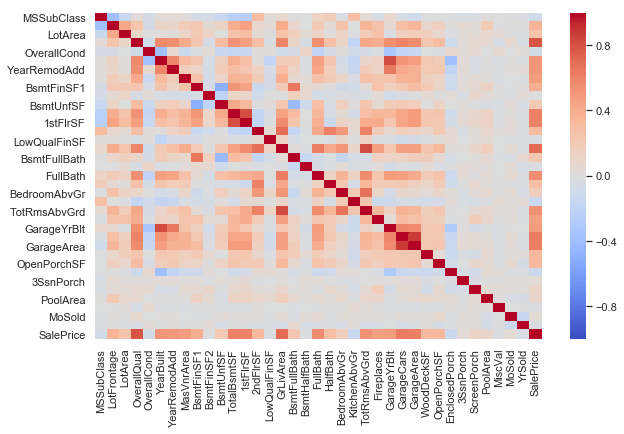

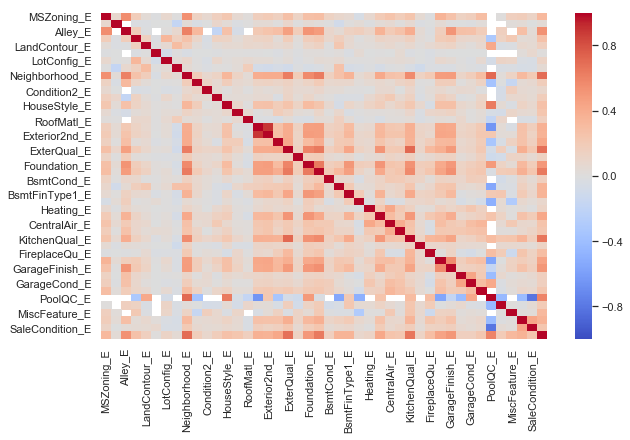

In [87]:
plt.figure(1,figsize=(10,6))
corr=train_data[quantative+['SalePrice']].corr()
sns.heatmap(corr,cmap='coolwarm',vmin=-1,vmax=1)
plt.figure(2,figsize=(10,6))
corr=train_data[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr,cmap='coolwarm',vmin=-1,vmax=1)

0.754887428653318


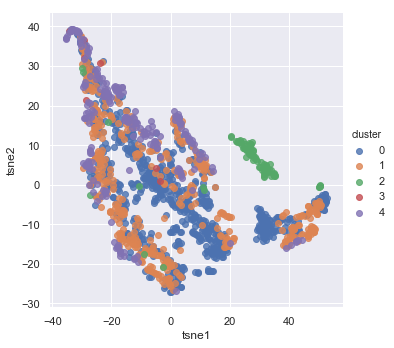

In [6]:
features=quantative+qual_encoded
#TSNE->고차원 데이터를 저차원으로 군집화,시각화 
#n_components->저차원
model=TSNE(n_components=2,random_state=0,perplexity=50)
X=train_data[features].fillna(0.).values
#fit_transform->훈련했던 데이터에만 적용할 수 있기 때문
tsne=model.fit_transform(X)

#pca에 적용하기 위한 전처리
#standard scaler->각 특성의 분산=1
std=StandardScaler()
s=std.fit_transform(X)
#n_components->사용할 데이터의 개수
pca=PCA(n_components=30)
pca.fit(s)
pc=pca.transform(s)
#KMeans(k평균)->데이터의 어떤 영역을 대표하는 클러스터 중심 찾기
#데이터를 가까운 클러스터 중심으로 할당하고 할당된 데이터 포인트들의 평균으로 클러스터 중심 다시 정함
#클러스터에 할당되는 데이터 포인트에 변화가 없을 때 알고리즘 종료
kmeans=KMeans(n_clusters=5)
kmeans.fit(pc)
#tsne를 2차원으로 설정했기 때문에 0,1만 사용
fr=pd.DataFrame({'tsne1':tsne[:,0],'tsne2':tsne[:,1],'cluster':kmeans.labels_})
#lmplot->선형관계확인 hue파라미터로 categorial 변수를 지정하여 카테고리별로
#각각 데이터의 분포와 선형 관계를 표시할 수 있다.
#fit_reg->선표시 없애줌
sns.lmplot(data=fr,x='tsne1',y='tsne2',hue='cluster',fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

In [7]:
train_data.drop(['Id'],axis=1,inplace=True)
test_data.drop(['Id'],axis=1,inplace=True)

train_data=train_data[train_data.GrLivArea<4500]
#log1p->log(1+x)
train_data['SalePrice']=np.log1p(train_data['SalePrice'])

train_features=train_data.drop(['SalePrice'],axis=1)
test_features=test_data
features=pd.concat([train_features,test_features])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [50]:
print(features.shape)
features.head()

(2917, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [8]:
nan_index=features.isnull().sum()
nan_index_d=features.isnull().sum().reset_index()
nan_list=[x for x in nan_index_d['index'] if nan_index[x]!=0]
nan_list.remove('LotFrontage')
for l in nan_list:
    if features[l].dtype=='object':
        features[l]=features[l].fillna('None')
    else:
        features[l]=features[l].fillna(0)

In [9]:
features['LotFrontage']=features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numerics=[x for x in features.columns if features[x].dtype!='object']

#skew->왜도(비대칭도) 값이 클수록 비대칭이 심한 것 *첨도->kurtosis(뾰족한 정도)
#왜도가 0.5보다 큰경우 데이터가 평균 기준 왼쪽, -0.5보다 작은 경우 오른쪽으로 쏠림
#첨도가 0보다 큰 경우 정규분포보다 뽀족함, 음수인 경우 정규분포보다 완만함
skew_features=features[numerics].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
high_skew=skew_features[skew_features>0.5]
skew_index=high_skew.index

#box cox->차분, 로그변환과 같이 비정상확률과정을 정상확률과정로 변환하는 방법
#정상확률과정->시간에 관계없이 확률 분포가 일정한 확률과정/ 비정상->시간이 지남에 따라 분산 혹은 기댓값이 달라짐
#차분->연이은 값의 차이 ex) yt-(yt-1)
#로그 변환->표준편차가 자료의 크기에 비례하여 증가하거나 지수함수적으로 증가하는 경향을 보일 때
#box cox->정규분포가 아닌 자료를 정규분포로 변환하기 위해 사용
for i in skew_index:
    features[i]=boxcox1p(features[i],stats.boxcox_normmax(features[i]+1))

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [10]:
#데이터 정리->필요없는 데이터 버리고 합치기
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])
features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
final_features=pd.get_dummies(features)
X=final_features.iloc[:len(y),:]
X_sub=final_features.iloc[len(y):,:]

#kfold->교차검증에서 k개의 폴드를 생성해서 실시 n_split->k
kfolds=KFold(n_splits=10,shuffle=True,random_state=42)

#rmse->root mean squared error
def rmse(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))
#cv->교차검증시 구분 기준(어떤 식으로 데이터를 나눌 것인지)
def cv_rmse(model,X=X):
    rmse=np.sqrt(-cross_val_score(model,X,y,scoring='neg_mean_squared_error',cv=kfolds))
    return rmse

In [12]:
#회귀모델 생성

#alpha->훈련 세트의 성능 대비 모델의 단순 정도 클수록 일반화(단순화)
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

#make_pipeline->여기서는 데이터 전처리와 학습을 연결하는 역할
#RobustScaler->중앙값과 사분 범위(interquartile range)사용, 아웃라이어의 영향 최소화
#IQR(interquartile range)->중앙값(Q2)과 중앙값아래에서 중앙값(Q1) 위에서 중앙값(Q3)을 이용해서 데이터의 분포 측정(클수록 데이터가 많이 흩어진 것))

#ridge->l2 norm적용(가중치의 제곱합을 최소화)
#모든 변수를 사용하기 때문에 계수값이 작아지고 모델이 복잡, 성능이 저하될 수 있음
#모델의 복잡성 때문에 큰 alpha값을 넘겨주는 듯
ridge=make_pipeline(RobustScaler(),RidgeCV(alphas=alphas_alt,cv=kfolds))
#lasso->l1 norm적용(가중치의 절댓값의 합을 최소화)
#변수들끼리 상관관계가 클 때 하나를 제외한 다른 변수의 계수를 0으로 함. 정보 손실에 따른 정확성 감소
lasso=make_pipeline(RobustScaler(),LassoCV(max_iter=1e7,alphas=alphas2,random_state=42,cv=kfolds))
#elastic net->l1, l2 norm 모두를 제약조건으로 가짐 두 개의 하이퍼모수(alpha)를 가짐
elasticnet=make_pipeline(RobustScaler(),ElasticNetCV(max_iter=1e7,alphas=e_alphas,cv=kfolds,l1_ratio=e_l1ratio))
#epsilon->허용오차, C->작을 수록 모델 단순화, gamma->클수록 최적화
svr=make_pipeline(RobustScaler(),SVR(C=20,epsilon=0.008,gamma=0.0003))

In [13]:
#gbm(gradient boosting regressor)->셋 중 최악, 느리고 부정확
#xgboost와 lgbm은 데이터에 따라 성능 차이가 있을 수 있으므로 모두 시도해보기
#xgboost->lgbm보다 조금 느리지만 별 차이 없음, 정확도는 lgbm과 비슷 / level wise
#lgbm(light gbm)->훈련 빠르고 정확도 높음, 데이터가 1만개 이하면 과적합의 위험 / leaf wise


#n_estimators->boosting stage의 수, max_depth->각 regressor estimators의 최대 깊이
#max_features->best split에서 고려할 특징의 수(sqrt: 특징 수의 루트값만큼)
#min_samples_leaf->모델이 고려해야할 요소지만 제약함으로써 
gbr=GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,\
                              max_features='sqrt',min_samples_leaf=15,min_samples_split=10,loss='number',random_state=42)
#num_leaves->트리의 노드 개수,n_estimators->앙상블에 사용될 트리 개수(많을 수록 복잡도 커짐)
#bagging_fraction->feature fraction과 비슷하지만 특성이 아닌 데이터의 일부분을 선택함.
#bagging_freq->0이면 bagging이 없는 것이고 k면 k번의 반복마다 bagging을 수행하겠다는 것이다.
#feature_fraction->매 반복마다 어느 정도의 특성을 사용할지, 여기서 20%
#~~seed->random seed, max_bin->특징 값들이 저장할 최대 bin 수
lightgbm=LGBMRegressor(objective='regression',num_leaves=4,learning_rate=0.01,n_estimators=5000,\
                      max_bin=200,bagging_fraction=0.75,bagging_freq=5,bagging_seed=7,\
                      feature_fraction=0.2,feature_fraction_seed=7,verbose=-1)
#colsample_bytree->트리마다 feature샘플링 비율
#reg_lambda, reg_alpha->각각 L2,L1정규화 파라미터
xgboost=XGBRegressor(learning_rate=0.01,n_estimators=3460,max_depth=3,min_child_weight=0,gamma=0,\
                    subsample=0.7,colsample_bytree=0.7,objective='reg:linear',nthread=-1,seed=27,
                    scale_pos_weight=1,reg_alpha=0.00006)

In [14]:
stack_gen=StackingCVRegressor(regressors=(ridge,lasso,elasticnet,gbr,xgboost,lightgbm),\
                              meta_regressor=xgboost,use_features_in_secondary=True)

In [ ]:
elastic_model=elasticnet.fit(X,y)
lasso_model=lasso.fit(X,y)
ridge_model=ridge.fit(X,y)
svr_model=svr.fit(X,y)
gbr_model=gbr.fit(X,y)
xgb_model=xgboost.fit(X,y)
lgb_model=lightgbm.fit(X,y)
stack_model=stack_gen.fit(np.array(X),np.array(y))

In [1]:
def blend_models_predict(X):
    return(0.1*elastic_model.predict(X)+0.05*lasso_model.predict(X)+0.1*ridge_model.predict(X)+\
           0.1*svr_model.predict(X)+0.1*gbr_model.predict(X)+0.15*xgb_model.predict(X)+\
           0.1*lgb_model.predict(X)+0.3*stack_model.predict(np.array(X)))

In [ ]:
print('RMSE score on train data')
print(rmse(y,blend_model_predict(X)))